In [1]:
import pandas as pd
import numpy as np
#import graph_tool.all as gt
from os import path
from json import load
from collections import Counter, defaultdict

# Import triples

In [2]:
clustered_triples = True

In [3]:
if clustered_triples:
    file_names = ['triples_wizardLM_filtering.json']
    folder_path = path.join('..','..' ,'outputs', 'genSRL', 'clustered_t80')
else:
    file_names = ['triples_wizardLM_filtering_setA.json', 'triples_wizardLM_filtering_setB.json', 'triples_wizardLM_filtering_setC.json', 'triples_wizardLM_filtering_setD.json', 'triples_wizardLM_filtering_setE.json']
    folder_path = path.join('..', 'outputs', 'genSRL')

In [4]:
triple_data = dict()
for file_name in file_names:
    file_path = path.join(folder_path, file_name)
    with open(file_path) as fp:
        triple_data.update(load(fp))
print("COMPANIES:", len(triple_data.keys()), '\n')
print('\n'.join([ f'{idk + 1}) {companyName}'for idk, companyName in enumerate(sorted(triple_data.keys()))]))

COMPANIES: 128 

1) 3M Corporation
2) 3i Group plc
3) Activision Blizzard Inc
4) Adecco Group AG
5) Adidas AG
6) Air Canada
7) Air Liquide SA
8) Airbus SE
9) Alcon Inc
10) Alibaba Group Holding Limited
11) Alphabet Inc
12) Aluminum Corporation of China Limited
13) Amazoncom Inc
14) American Electric Power Company Inc
15) Amplifon
16) Apple Inc
17) ArcelorMittal SA
18) Assicurazioni Generali SpA
19) AstraZeneca PLC
20) AstraZeneca plc
21) BPER Banca SpA
22) Baidu Inc
23) Banco Santander SA
24) Bank of America Corp BofA
25) Bayer AG
26) British American Tobacco PLC
27) British American Tobacco plc
28) British Land Co PLC The
29) Broadcom Inc
30) Builders FirstSource Inc
31) CF Industries Holdings Inc
32) Campbell Soup Company
33) Canadian Pacific Railway Limited
34) Canon Inc
35) CarMax Inc
36) China Evergrande Group
37) China Petroleum Chemical Corporation
38) Cisco Systems Inc
39) Coca Cola
40) Commonwealth Bank of Australia
41) Croda International plc
42) Daikin Industries Ltd
43) Del

In [5]:
raw_data = []
for companyName, triples in triple_data.items():
    for triple in triples:
        raw_data.append({
            'company': companyName,
            'category': triple['esg_category'],
            'predicate': triple['predicate'],
            'object': triple['object']
        })
df = pd.DataFrame(raw_data)
df['action'] = df['category'].str.upper() + ': ' + df['predicate'].str.lower() #+ ' ' + df['object'].str.lower() 
display(df)

# Get company info
company_info = pd.read_excel(path.join('..', '..','data', 'companySectors_auto.xlsx'), index_col = 0)
company_info = company_info.loc[df['company'].unique(), :]

,company,category,predicate,object,action
0,3M Corporation,Access to Basic Services,Availability of education,"In areas including medical, dental, orthodonti...",ACCESS TO BASIC SERVICES: availability of educ...
1,3M Corporation,Access to Basic Services,Challenges related to,Land ownership and engagement in forestry,ACCESS TO BASIC SERVICES: challenges related to
2,3M Corporation,Access to Healthcare,Availability of education,A broad range of platforms to help assure acce...,ACCESS TO HEALTHCARE: availability of education
3,3M Corporation,Accessibility,Approaching,Accessibility with the understanding that our ...,ACCESSIBILITY: approaching
4,3M Corporation,Accessibility,Design for,Easily printable website pages,ACCESSIBILITY: design for
...,...,...,...,...,...
49792,adidas AG,Supply Chain,Description of,"The greatest labor and environmental, health, ...",SUPPLY CHAIN: description of
49793,adidas AG,Supply Chain,Number of,Tier 1 suppliers and suppliers beyond Tier 1,SUPPLY CHAIN: number of
49794,adidas AG,Supply Chain,Working with,520 independent supplier facilities (Tier 1),SUPPLY CHAIN: working with
49795,adidas AG,Product Sustainability,Standardization of,SASB's standards for sustainability disclosure,PRODUCT SUSTAINABILITY: standardization of


# Create the graph

## Compute the adjacency matrices

In [6]:
def foreach_triple(triple, cols, matrix_df):
    matrix_df.loc[triple[cols[0]], triple[cols[1]]] = 1 

adjacency_matrices = dict()
edge_lists = dict()
biparite_graphs = [['category', 'predicate'], ['company', 'category'], ['company', 'action']]    
for cols in biparite_graphs:#[::-1]:
    
    versionName = cols[0] +'_' + cols[1]
    print(f"\nVERSION: {versionName}")
    
    # Select the partial triple
    partial_triples = df[cols]
    edge_lists[versionName] = partial_triples.drop_duplicates().sample(frac = 1).reset_index(drop = True)
    display(edge_lists[versionName])
    
    # Retrieve the unique values
    item_row = sorted(partial_triples[cols[0]].unique())
    item_col = sorted(partial_triples[cols[1]].unique()) 
    print(f"--> {cols[0].upper()}: {len(item_row)}\n--> {cols[1].upper()}: {len(item_col)}")      

    # Create the adiacency matrix
    matrix_df = pd.DataFrame(index=item_row, columns=item_col, data = 0, dtype=np.int8)
    partial_triples.apply(func = lambda row: foreach_triple(row, cols, matrix_df), axis = 1) # type: ignore
    
    new_column_order = matrix_df.sum(axis = 0).sort_values(ascending = False).index.tolist()
    matrix_df = matrix_df[new_column_order]
    
    adjacency_matrices[versionName] = matrix_df
    
    num_edges = matrix_df.sum().sum()
    print('--> EDGES:', num_edges)
    
    # Compute the density
    print(f"[Density:", round((matrix_df.sum().sum() / (matrix_df.shape[0] * matrix_df.shape[1])) * 100, 2), "%]")
    display(matrix_df)


VERSION: category_predicate


,category,predicate
0,Corporate Governance,Addresses
1,Environmental,Deal with
2,Waste,Establishment of
3,Employee Development,Making it easier
4,Site Closure,Review of
...,...,...
19569,Electric Vehicles,Introduction of
19570,Financial Inclusion,Conversion to
19571,Education,Carrying out
19572,Human Rights,Assessment using labor issues-specific questio...


--> CATEGORY: 542
--> PREDICATE: 4864
--> EDGES: 19574
[Density: 0.74 %]


,Commitment and involvement with,Advisory support for,Participation in,Partnership with,Establishment of,Use of,Development and implementation of,Development of,Assessment of,Contribution to,...,In ongoing Phase 1 trials,In order to,"In particular, this happens in",In place for many years,In place since 1996,"In principle, Hyundai aims to provide accurate and correct information",In sync with,In the case where climate change measures do not progress,In this manner,Kickstarted
AI/ML,1,0,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
Access Control,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Access to Assets,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Access to Basic Services,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Access to Education,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Working Hours,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Working Model,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Workplace Design,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Workplace Flexibility,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



VERSION: company_category


,company,category
0,DuPont,Supplier Assessment
1,Deutsche Bank AG,Employment Practices
2,STMicroelectronics,Marketing
3,Air Liquide SA,Safety
4,Royal Dutch Shell PLC,Environmental
...,...,...
7450,Alcon Inc,Public Health
7451,American Electric Power Company Inc,Customer Relationship
7452,Korean Air Lines Co Ltd,Employee Safety
7453,First Republic Bank CA,Business Ethics


--> COMPANY: 128
--> CATEGORY: 542
--> EDGES: 7455
[Density: 10.75 %]


,Environmental,Supply Chain,Climate Risk Management,Corporate Governance,Energy,Product Sustainability,Community and Society,Biodiversity,Air Emissions,Employee Safety,...,Market Expansion,Market Selection,Marketing Responsibly,Coal,Media,Media Ethics,Closure,Military,Climate Lobbying,Office Relocation
3M Corporation,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3i Group plc,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Activision Blizzard Inc,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Adecco Group AG,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Adidas AG,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Walmart Inc,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Walt Disney Co,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Washington Real Estate Investment Trust,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Yamana Gold Inc,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,0,0



VERSION: company_action


,company,action
0,3M Corporation,BOARD DIVERSITY: criteria for
1,Airbus SE,COLLECTIVE BARGAINING: coverage of
2,Banco Santander SA,BIODIVERSITY: commitment and involvement with
3,British American Tobacco plc,ACCESS TO BASIC SERVICES: identification of
4,Canadian Pacific Railway Limited,BOARD DIVERSITY: extension of the mandate
...,...,...
43164,Daikin Industries Ltd,ENERGY EFFICIENCY: promotion of
43165,STMicroelectronics,ANONYMOUS REPORTING: review of
43166,Croda International plc,ENVIRONMENTAL AUDITING: avoided
43167,Sligro Food Group NV,SUPPLIER ETHICS: inclusion of


--> COMPANY: 128
--> ACTION: 19574
--> EDGES: 43169
[Density: 1.72 %]


,AIR EMISSIONS: reduction of,ENERGY: reduction of,PHILANTHROPY: advisory support for,PHILANTHROPY: donation by,COMMUNITY AND SOCIETY: advisory support for,CLIMATE RISK MANAGEMENT: assessment of,BIODIVERSITY: commitment and involvement with,CORPORATE GOVERNANCE: commitment and involvement with,WATER: reduction of,PHILANTHROPY: contribution to,...,EMPLOYEE DEVELOPMENT: gri 401 employment (2016) personnel management,EMPLOYEE DEVELOPMENT: grievance mechanism,EMPLOYEE DEVELOPMENT: grow and elevate,EMPLOYEE DEVELOPMENT: guaranteeing,EMPLOYEE DEVELOPMENT: guided by,EMPLOYEE DEVELOPMENT: handling of,EMPLOYEE DEVELOPMENT: handling of employee concerns,EMPLOYEE DEVELOPMENT: harnesses,EMPLOYEE DEVELOPMENT: help employees reach their full potential,YOUTH ENGAGEMENT: tackling
3M Corporation,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3i Group plc,0,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
Activision Blizzard Inc,0,0,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Adecco Group AG,1,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Adidas AG,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Walmart Inc,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Walt Disney Co,0,0,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Washington Real Estate Investment Trust,1,1,0,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
Yamana Gold Inc,1,1,0,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
import condor
from json import dumps

In [8]:
# Create the edge list
edge_list = df[['company', 'category']].drop_duplicates().sample(frac=1).reset_index(drop=True)
display(edge_list)

# Create the object
co = condor.condor_object(dataframe = edge_list, silent=False) # modified: Graph.DataFrame(..., use_vids=False)

# Computes the initial community structure and updates the condor object.
co.initial_community(method = 'LCS')
co.brim()

# ['net', 'silent', 'graph', 'reg_names', 'tar_names', 'index_dict', 'modularity', 'reg_memb', 'tar_memb', 'Qcoms'
print('-' * 50, 'RESULTS', '-' * 50)
#for key, value in co.__dict__.items():
#    print('-' * 50, key.upper(), '-' * 50)
#    display(value)
    
#co.tar_memb
communities = defaultdict(lambda: defaultdict(list))
if isinstance(co.reg_memb, pd.DataFrame):
    for nodeName, communityId in co.reg_memb.to_numpy():
        communities[communityId]['company'].append(nodeName)
if isinstance(co.tar_memb, pd.DataFrame):
    for nodeName, communityId in co.tar_memb.to_numpy():
        communities[communityId]['category'].append(nodeName)

print("MODULARITY:", np.round(co.modularity, 4))
print('-' * 50, f'COMMUNITIES: {len(communities.keys())}', '-' * 50)
communities = dict(sorted(communities.items(), key = lambda x: (len(x[1]['company']), len(x[1]['category'])), reverse = True))
for communityId, nodes in communities.items():
    print(f"COMMUNITY ID: {communityId} --> {len(nodes['company'])} companies || {len(nodes['category'])} categories")
    #display(nodes)

,company,category
0,CarMax Inc,Product Safety
1,Moderna Inc,Pharmacovigilance
2,Enel SpA,Government Relations
3,Lockheed Martin Corp,Human Resources
4,Royal Bank of Canada,Pay Equity
...,...,...
7450,Canadian Pacific Railway Limited,Corporate Governance
7451,Paramount Resources Ltd,Environmental
7452,Microsoft Corporation,Renewable Energy
7453,British American Tobacco plc,Water


Object creation:
Unweighted network. Weights initialized as 1.
  Elapsed time: 0.02 sec.
Initial community structure without projection:
Initial modularity:  0.12502649251196873
  Elapsed time: 0.02 sec.
Matrix computation:
  Elapsed time: 0.24 sec.
BRIM: 
0.1371357678825018
0.13734858963753457
0.13734858963753457
  Elapsed time: 0.02 sec.
-------------------------------------------------- RESULTS --------------------------------------------------
MODULARITY: 0.1373
-------------------------------------------------- COMMUNITIES: 8 --------------------------------------------------
COMMUNITY ID: 2 --> 36 companies || 86 categories
COMMUNITY ID: 1 --> 29 companies || 83 categories
COMMUNITY ID: 0 --> 16 companies || 79 categories
COMMUNITY ID: 7 --> 13 companies || 75 categories
COMMUNITY ID: 6 --> 12 companies || 66 categories
COMMUNITY ID: 5 --> 10 companies || 63 categories
COMMUNITY ID: 3 --> 8 companies || 56 categories
COMMUNITY ID: 4 --> 4 companies || 34 categories


In [9]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.scale import LogScale
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from os import makedirs
from json import dump
from string import ascii_uppercase

In [10]:
node_colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan', 'magenta']
sector_colors = dict(zip(company_info['Sector'].unique(), node_colors))
company_colors = dict(zip(company_info.index, company_info['Sector'].map(sector_colors)))
dist_graph_colors = ['#EF5350', '#0288D1','#8BC34A'] # #7FBA00

In [11]:
main_saving_folder = path.join('..','..', 'outputs', 'bipartite_analyses', 'pycondor')
normalized_degreeDistributions = True
community_detection = False

In [12]:
#sns.set_context("notebook") # makes the text in the plots larger, for better visibility
#%config InlineBackend.figure_format = 'svg' # makes the plots HD in the notebook
mpl.rcParams["figure.autolayout"] = True # enables tigh layout. Better multiplots
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["font.family"] = "Helvetica"

In [13]:
import networkx as nx


category_predicate


,category,predicate
0,Corporate Governance,Addresses
1,Environmental,Deal with
2,Waste,Establishment of
3,Employee Development,Making it easier
4,Site Closure,Review of
...,...,...
19569,Electric Vehicles,Introduction of
19570,Financial Inclusion,Conversion to
19571,Education,Carrying out
19572,Human Rights,Assessment using labor issues-specific questio...


--> Compensation
--> Equipment
--> Outsourcing 


[STATS] Main nodes: 542 | Secondary nodes: 4861

AVERAGE CLUSTERING: 0.1972
DENSITY: 0.0074
DEGREE DISTRIBUTION:


,count,mean,std,min,25%,50%,75%,max
degree,4861.0,4.022012,8.332057,1.0,1.0,1.0,3.0,113.0


DEGREE DISTRIBUTION (normalized):


,count,mean,std,min,25%,50%,75%,max
degree,4861.0,0.7421,1.5373,0.1845,0.1845,0.1845,0.5535,20.8487


,degree
Commitment and involvement with,20.8487
Advisory support for,18.8192
Partnership with,17.8967
Participation in,17.8967
Establishment of,17.3432
...,...
"In principle, Hyundai aims to provide accurate and correct information",0.1845
In sync with,0.1845
In the case where climate change measures do not progress,0.1845
In this manner,0.1845


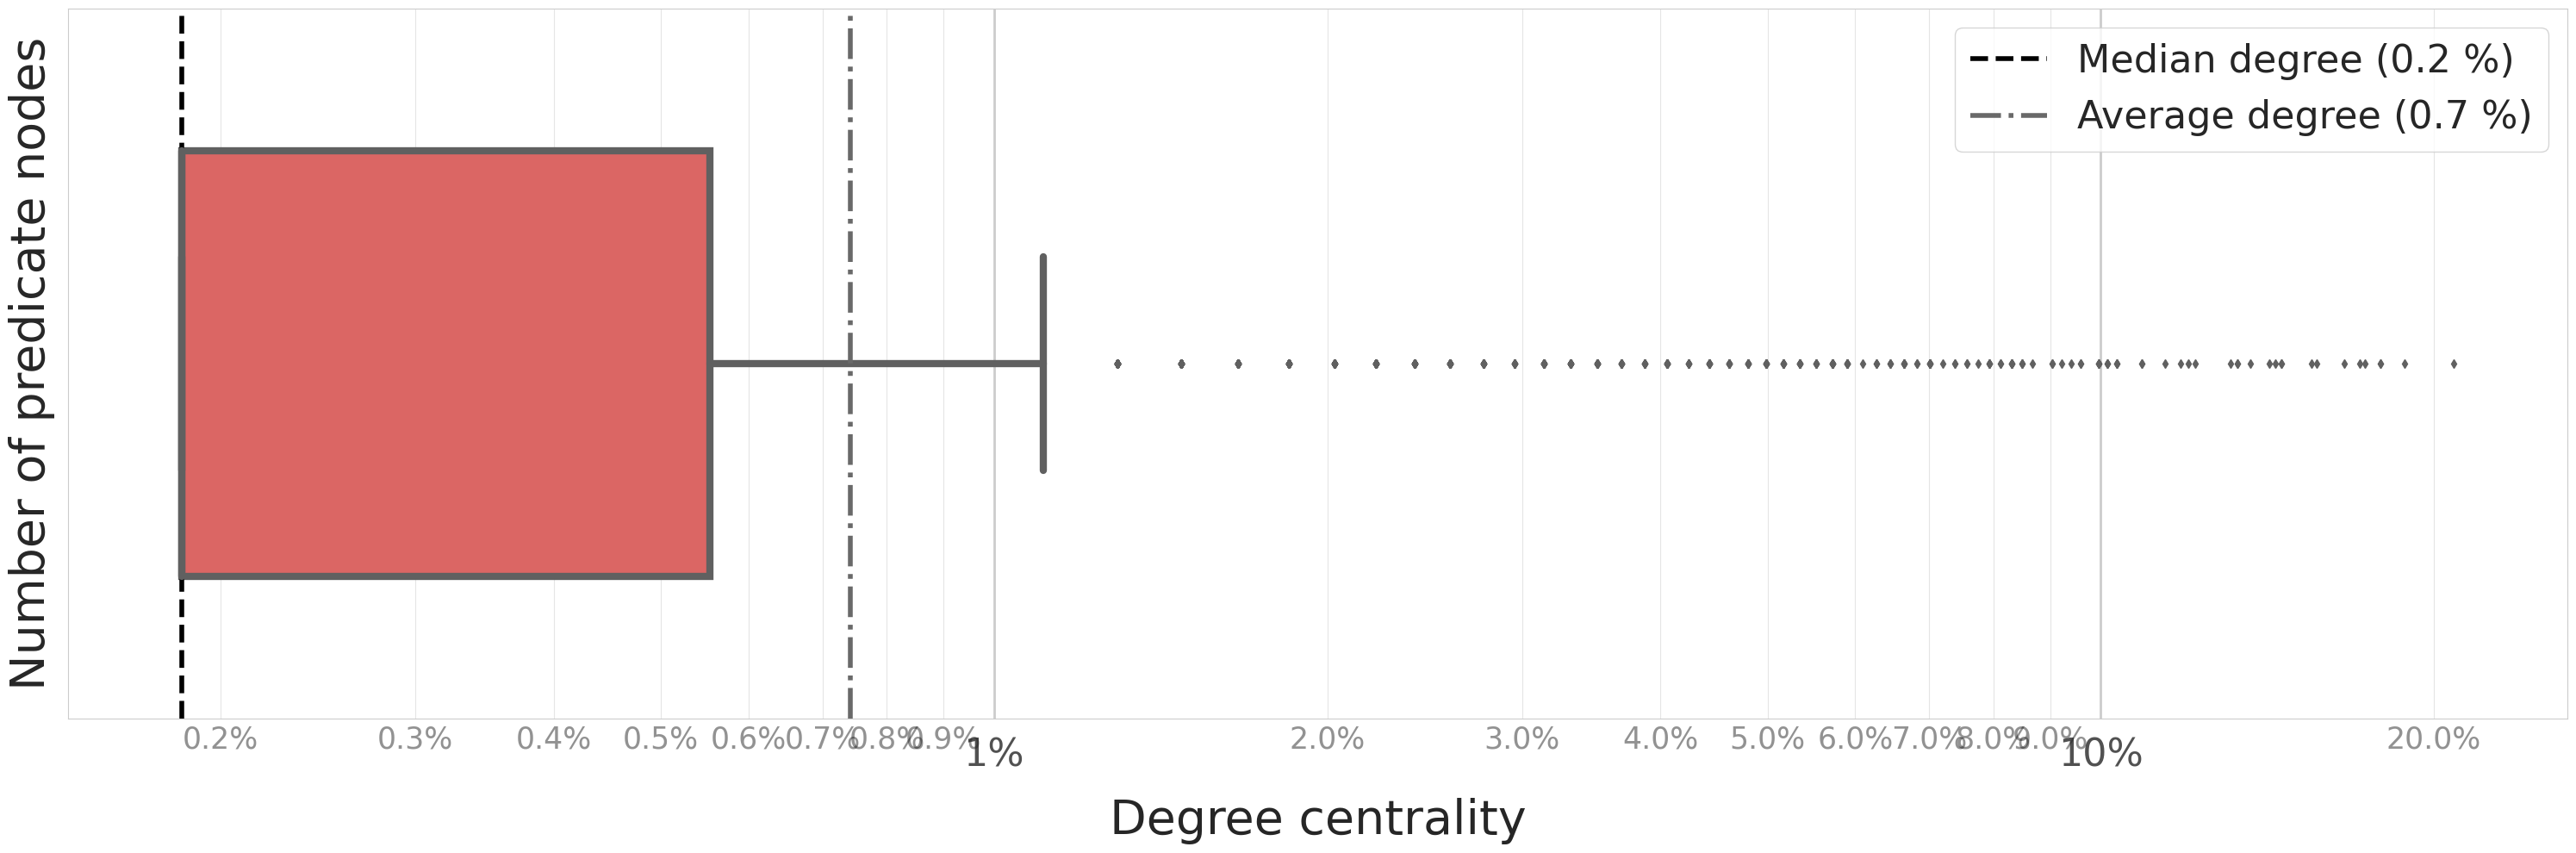

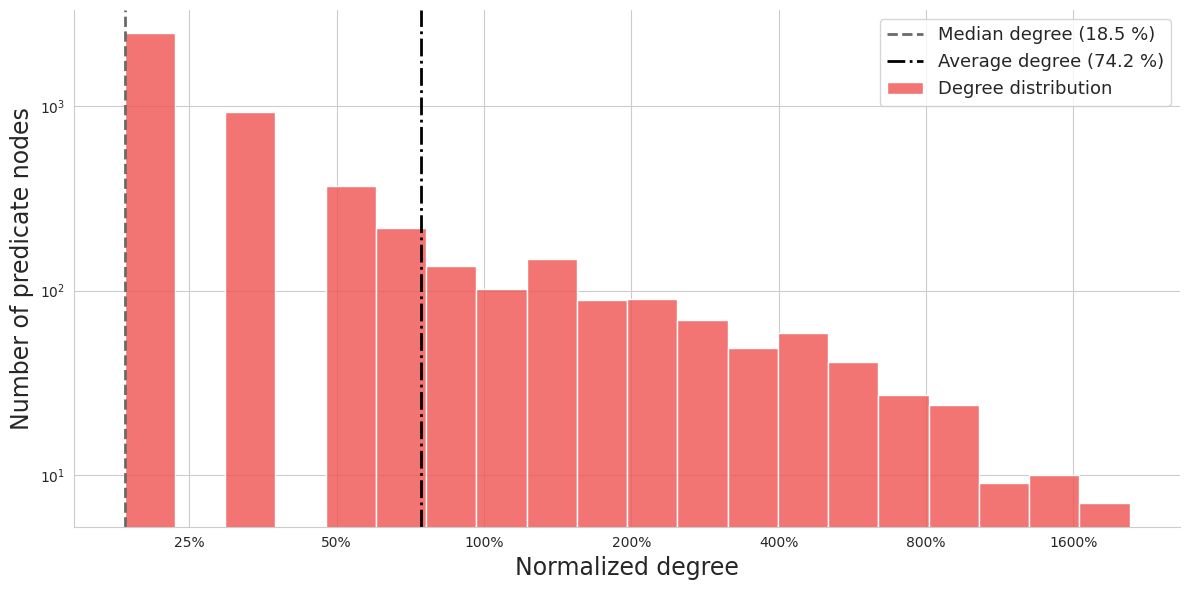


company_category


,company,category
0,DuPont,Supplier Assessment
1,Deutsche Bank AG,Employment Practices
2,STMicroelectronics,Marketing
3,Air Liquide SA,Safety
4,Royal Dutch Shell PLC,Environmental
...,...,...
7450,Alcon Inc,Public Health
7451,American Electric Power Company Inc,Customer Relationship
7452,Korean Air Lines Co Ltd,Employee Safety
7453,First Republic Bank CA,Business Ethics



[STATS] Main nodes: 128 | Secondary nodes: 542

AVERAGE CLUSTERING: 0.1299
DENSITY: 0.1075
DEGREE DISTRIBUTION:


,count,mean,std,min,25%,50%,75%,max
degree,542.0,13.754613,26.735867,1.0,1.0,2.0,9.75,123.0


DEGREE DISTRIBUTION (normalized):


,count,mean,std,min,25%,50%,75%,max
degree,542.0,10.7458,20.8874,0.7812,0.7812,1.5625,7.6172,96.0938


,degree
Environmental,96.0938
Supply Chain,95.3125
Climate Risk Management,94.5312
Energy,92.9688
Corporate Governance,92.9688
...,...
Land,0.7812
Environmental Crime,0.7812
Management,0.7812
Low-carbon Transition,0.7812


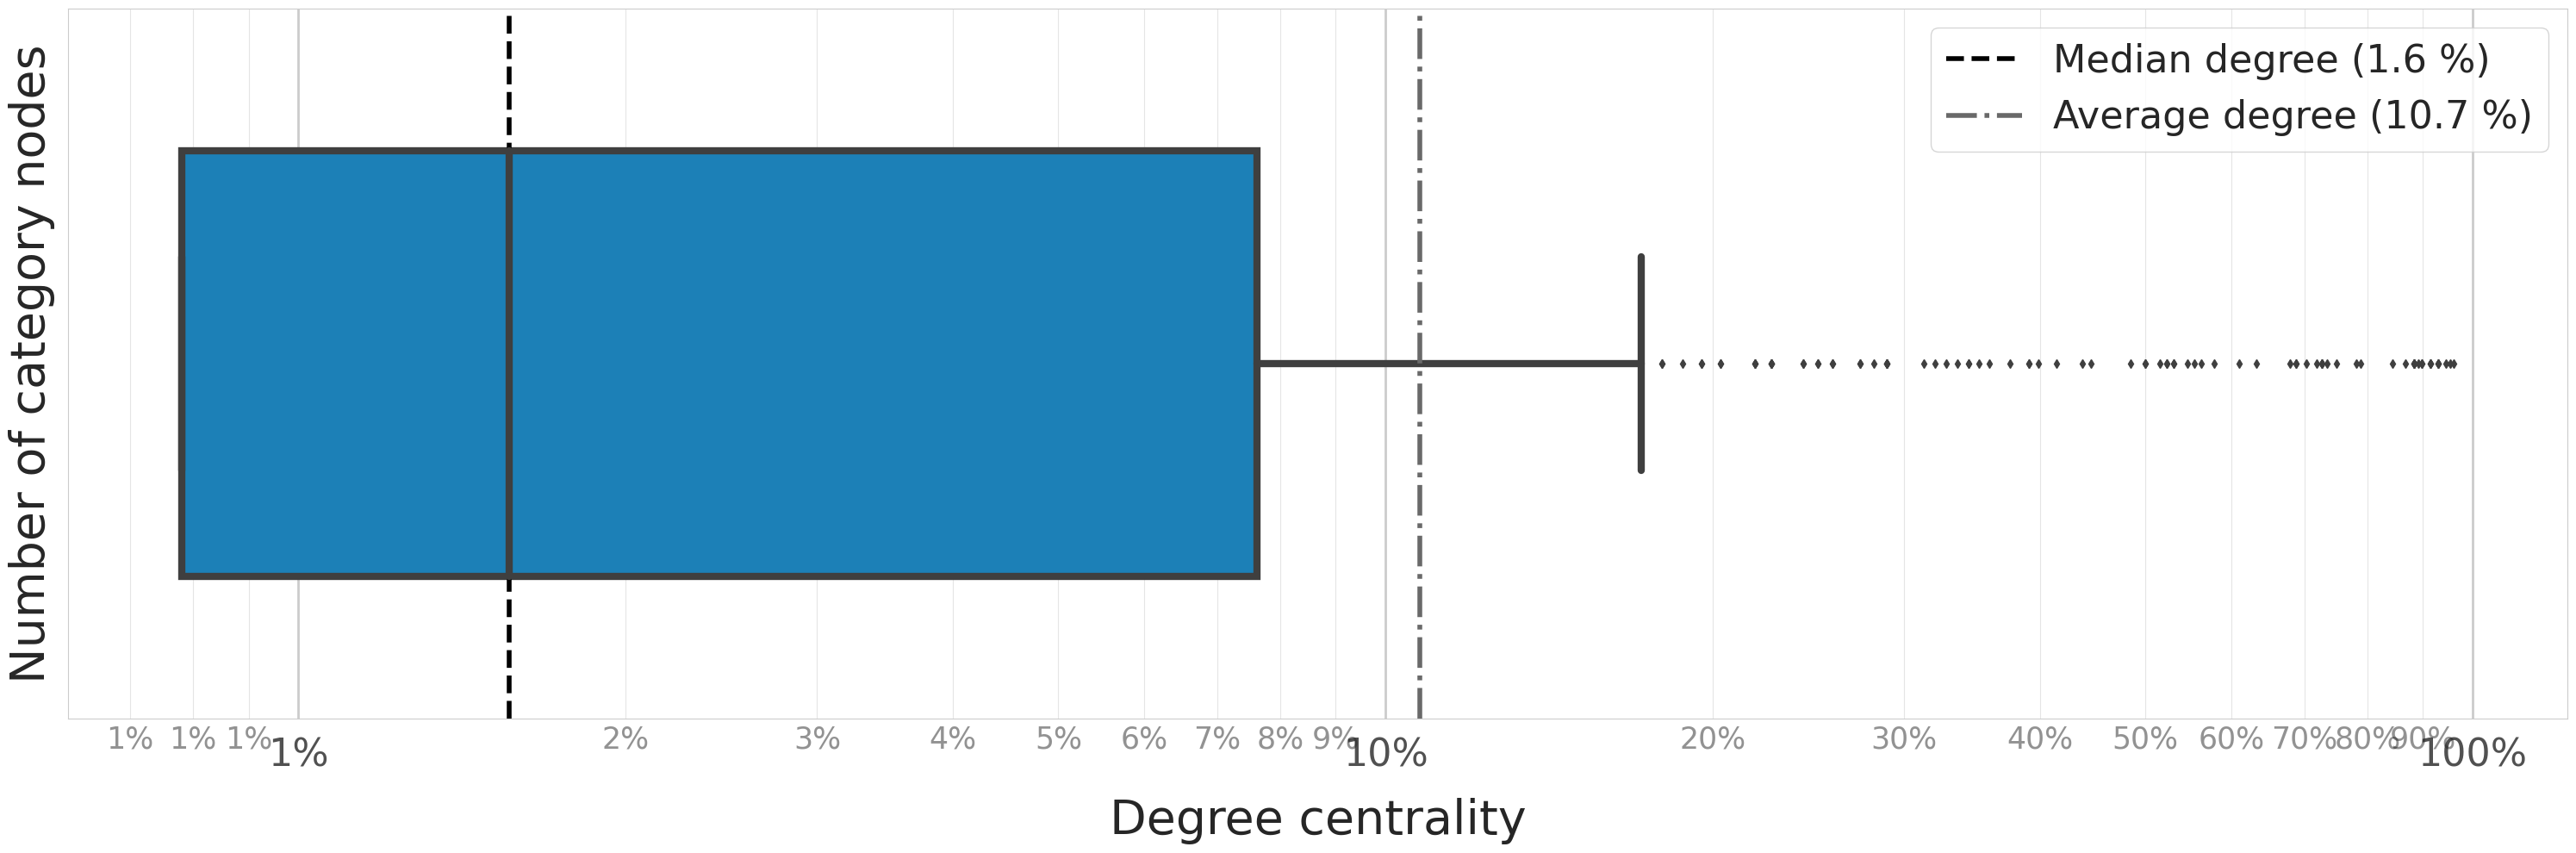

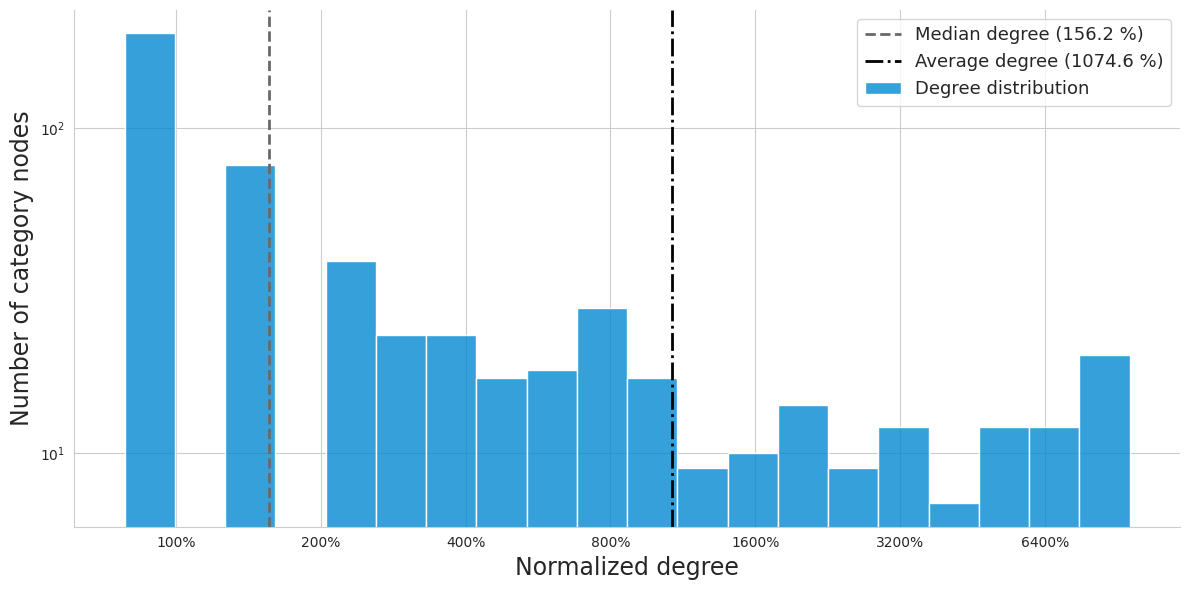


company_action


,company,action
0,3M Corporation,BOARD DIVERSITY: criteria for
1,Airbus SE,COLLECTIVE BARGAINING: coverage of
2,Banco Santander SA,BIODIVERSITY: commitment and involvement with
3,British American Tobacco plc,ACCESS TO BASIC SERVICES: identification of
4,Canadian Pacific Railway Limited,BOARD DIVERSITY: extension of the mandate
...,...,...
43164,Daikin Industries Ltd,ENERGY EFFICIENCY: promotion of
43165,STMicroelectronics,ANONYMOUS REPORTING: review of
43166,Croda International plc,ENVIRONMENTAL AUDITING: avoided
43167,Sligro Food Group NV,SUPPLIER ETHICS: inclusion of



[STATS] Main nodes: 128 | Secondary nodes: 19574

AVERAGE CLUSTERING: 0.3803
DENSITY: 0.0172
DEGREE DISTRIBUTION:


,count,mean,std,min,25%,50%,75%,max
degree,19574.0,2.205426,4.12168,1.0,1.0,1.0,2.0,90.0


DEGREE DISTRIBUTION (normalized):


,count,mean,std,min,25%,50%,75%,max
degree,19574.0,1.723,3.2201,0.7812,0.7812,0.7812,1.5625,70.3125


,degree
AIR EMISSIONS: reduction of,70.3125
ENERGY: reduction of,60.1562
PHILANTHROPY: advisory support for,59.3750
PHILANTHROPY: donation by,57.8125
COMMUNITY AND SOCIETY: advisory support for,54.6875
...,...
RESEARCH AND DEVELOPMENT: pairing with,0.7812
SUPPLY CHAIN: part of,0.7812
CUSTOMER RELATIONSHIP: building a roadmap of priority actions,0.7812
SUPPLIER ETHICS: assess,0.7812


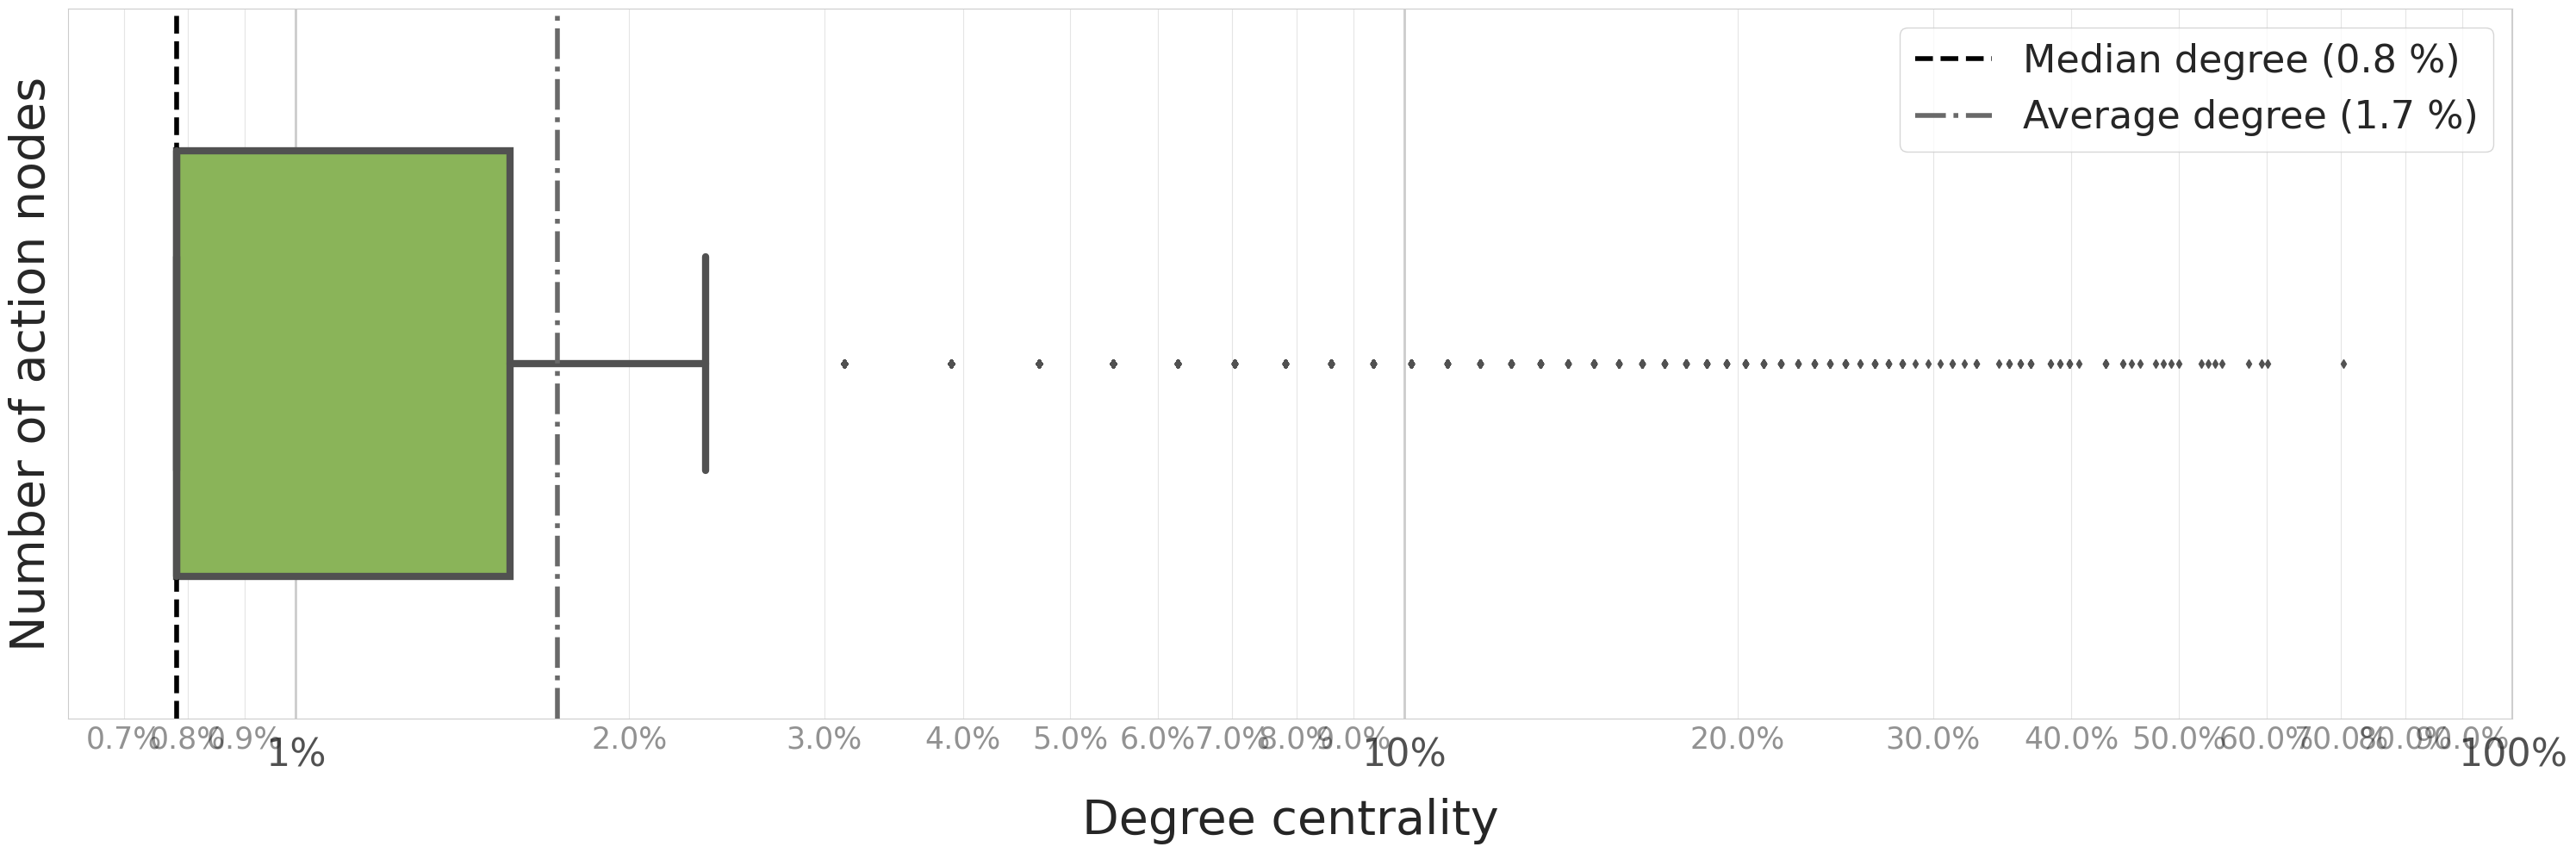

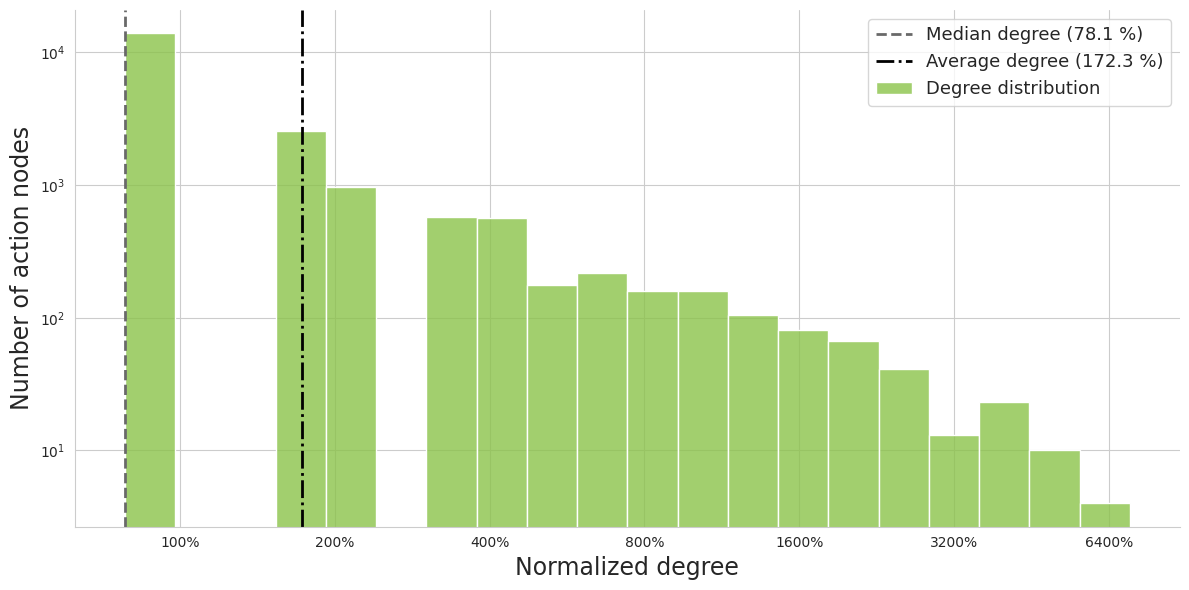

In [17]:


bipartite_stats = defaultdict(dict)
#distribution_figures, axes = plt.subplots(nrows = len(edge_lists.keys()), ncols = 1, figsize = (14, 5 * len(edge_lists.keys())))
#distribution_figures.suptitle('Degree distributions of the right nodes\n in bipartite graphs', fontsize = 40)
#distribution_figures.supylabel('Number of nodes', fontsize = 40)
sns.set_style("whitegrid")

for idk, (version, edge_list) in enumerate(edge_lists.items()):
    print(f"\n{version}")
    
    #if 'action' in version.lower():
    #    edge_list = edge_list.sample(frac = 0.1, random_state = 101).sort_values(by = 'company')
    #if 'predicate' in version.lower():
    #    edge_list = edge_list.sample(frac = 0.1, random_state = 101).sort_values(by = 'category')
    display(edge_list)

    # Add nodes
    graph = nx.Graph()
    nodes = {
        'main': edge_list.iloc[:, 0].unique(),
        'secondary': edge_list.iloc[:, 1].unique()
    }
    
    # Check if there are nodes in common
    interection = np.intersect1d(nodes['main'], nodes['secondary'])
    
    if len(interection) > 0:
        print(f'WARNING: There are {len(interection)} nodes in common between the two sets.')
        print('-->','\n--> '.join(interection), '\n')
        
        nodes['secondary'] = np.setdiff1d(nodes['secondary'], interection)
        edge_list = edge_list[~ edge_list.iloc[:, 1].isin(interection)]
    
    graph.add_nodes_from(nodes['main'], bipartite = 0)
    graph.add_nodes_from(nodes['secondary'], bipartite = 1)  
    
    print(f"\n[STATS] Main nodes: {len(nodes['main'])} | Secondary nodes: {len(nodes['secondary'])}\n")
    
    # Add edges
    graph.add_edges_from(edge_list.to_numpy())
    
    # Create folder
    saving_folder = path.join(main_saving_folder, version)
    graph_saving_folder = path.join(saving_folder, 'graphs')
    if not path.exists(graph_saving_folder):
        makedirs(graph_saving_folder)

    # Local density of connections
    bipartite_stats[version]['avg_cluster_coef'] =  np.round(bipartite.average_clustering(graph), 4)
    print("AVERAGE CLUSTERING:",bipartite_stats[version]['avg_cluster_coef'])
    
    # Density
    bipartite_stats[version]['density'] = np.round(bipartite.density(graph, nodes = nodes['main']), 4)
    print("DENSITY:", bipartite_stats[version]['density'])
    
    # Compute degree
    degree_mainN, degree_secondaryN = bipartite.degrees(graph, nodes = nodes['main'])
    node_degress = dict(degree_mainN)
    node_degress.update(dict(degree_secondaryN))
    
    # [STATS] Centrality (closeness, degree, betweenness)
    df = pd.DataFrame(index = list(graph.nodes.keys()))
    df['node_type'] = ['main' if node in nodes['main'] else 'secondary' for node in df.index]
    df['cluster_coef'] = bipartite.clustering(graph)
    df['closeness'] = bipartite.closeness_centrality(graph, nodes = nodes['main'], normalized = False)
    df['degree'] = node_degress
     
    # The degree centrality for a node v is the fraction of nodes it is connected to.
    df['degree_centrality'] = bipartite.degree_centrality(graph, nodes = nodes['main'])
    df['betweenness'] = bipartite.betweenness_centrality(graph, nodes = nodes['main'])
    
    # Degree distribution
    secondaryNodes_degreedistribution = df.loc[df['node_type'] == 'secondary', 'degree']#.map(np.log10)
    
    if normalized_degreeDistributions:
        print('DEGREE DISTRIBUTION:')
        display(secondaryNodes_degreedistribution.describe().to_frame().T)
        
        secondaryNodes_degreedistribution /= len(df[df['node_type'] == 'main'])
        secondaryNodes_degreedistribution *= 100 
        
        print('DEGREE DISTRIBUTION (normalized):')
        degree_stats = secondaryNodes_degreedistribution.describe().to_frame().T.round(4)
        display(degree_stats)        
        display(secondaryNodes_degreedistribution.sort_values(ascending = False).to_frame().round(4))
        
        fig = plt.figure(figsize = (30, 10))
        #sns.violinplot(x = secondaryNodes_degreedistribution, label = 'Degree distribution', orient = 'h',
        #               color = dist_graph_colors[idk], width = 1, alpha = .9, linewidth = 6, cut = 0, scale = 'area') # , , area
        
        #sns.boxenplot(x = secondaryNodes_degreedistribution, orient = 'h', color = dist_graph_colors[idk], scale = 'area')
        sns.boxplot(x = secondaryNodes_degreedistribution, orient = 'h', color = dist_graph_colors[idk], width = .6, linewidth = 6)
        
        
        # Outliers
        #low_outliers = degree_stats.loc['degree','25%'] - (degree_stats.loc['degree','75%'] - degree_stats.loc['degree','25%']) * 1.5 # type: ignore
        #high_outliers = degree_stats.loc['degree','75%'] + (degree_stats.loc['degree','75%']  - degree_stats.loc['degree','25%']) * 1.5 # type: ignore
        #outliers = secondaryNodes_degreedistribution[(secondaryNodes_degreedistribution < low_outliers) | (secondaryNodes_degreedistribution > high_outliers)]
        #sns.scatterplot(x = outliers, y=0, marker='o', color='black', alpha = .7, s = 50, ) # linewidth  = .1
        
        plt.axvline(secondaryNodes_degreedistribution.median(), color = 'black', linestyle = 'dashed', linewidth = 4, 
                      label = 'Median degree (' + str(round(secondaryNodes_degreedistribution.median(), 1) if normalized_degreeDistributions else int(round(secondaryNodes_degreedistribution.median(), 1))) + ' %)')
        plt.axvline(secondaryNodes_degreedistribution.mean(), color = 'dimgrey', linestyle = 'dashdot', linewidth = 4, #zorder = 1,
                      label = 'Average degree (' + str(round(secondaryNodes_degreedistribution.mean(), 1) if normalized_degreeDistributions else int(round(secondaryNodes_degreedistribution.mean(), 1))) + ' %)')
        
        # Axes 
        plt.ylabel(f"Number of {version.split('_')[-1]} nodes", fontsize = 40)
        plt.xlabel('Degree centrality' if normalized_degreeDistributions else 'Degree', fontsize = 40, labelpad = 20)
        
        plt.xscale("log")
        
        if 'action' in version.lower():
            plt.xlim(right = 100)
       
        plt.xticks(fontsize = 32, alpha = .8, y = -0.014)
        plt.xticks(minor = True, fontsize = 25, alpha = .5)

        plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals = 0))
        plt.gca().xaxis.set_minor_formatter(PercentFormatter(xmax=100, decimals = 1 if secondaryNodes_degreedistribution.median() <= 1 else 0))
        #plt.grid(True, which = 'both')
        plt.grid(axis = 'x', which = 'minor', alpha = .5)
        plt.grid(axis = 'x', which = 'major', alpha = 1, linewidth = 2)
        
        plt.legend(fontsize = 32)
        plt.tight_layout(pad = 2)
        plt.savefig(path.join(saving_folder, version.split('_')[-1] + '_degreeCentralityDist.pdf'))
        
        plt.show()
        
    # Plot the degree distribution
    #fig = plt.figure(figsize = (30, 10)
    sns.displot(secondaryNodes_degreedistribution, log_scale = (2, True), stat = 'count', kde = False, bins = 20, #'doane',
                label = 'Degree distribution', color = dist_graph_colors[idk], alpha = .8, height = 6, aspect = 2)
                #line_kws = {'alpha': 0.3, 'label' : 'Kernel Density Estimate (KDE)', 'zorder': 5000} ) 
    plt.axvline(secondaryNodes_degreedistribution.median(), color = 'dimgrey', linestyle = 'dashed', linewidth = 2, 
                      label = 'Median degree (' + str(round(secondaryNodes_degreedistribution.median() * 100, 1) if normalized_degreeDistributions else int(round(secondaryNodes_degreedistribution.median(), 1))) + ' %)')
    plt.axvline(secondaryNodes_degreedistribution.mean(), color = 'black', linestyle = 'dashdot', linewidth = 2, 
                      label = 'Average degree (' + str(round(secondaryNodes_degreedistribution.mean() * 100, 1) if normalized_degreeDistributions else int(round(secondaryNodes_degreedistribution.mean(), 1))) + ' %)')
    
    # Graphs settings
    #plt.set_title(f"{version.split('_')[1].upper()} NODES (bipartite graph {ascii_uppercase[idk]}: {version.split('_')[0]}-{version.split('_')[1].upper()})", fontsize = 20)
    #plt.set_tick_params(axis = 'both', which = 'major', labelsize = 12)
    
    # LEGEND
    #plt.legend(fontsize = 14)
    #handles, labels = plt.gca().get_legend_handles_labels()
    #plt.legend([handles[idx] for idx in [1, 2, 3, 0]],[labels[idx] for idx in [1, 2, 3, 0]], fontsize = 14)
    plt.legend(fontsize = 13)
    #plt.xlim(0, 1)
    
    plt.xlabel('Normalized degree' if normalized_degreeDistributions else 'Degree', fontsize = 17)
    plt.ylabel(f"Number of {version.split('_')[-1]} nodes", fontsize = 17)
    plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals = 0))
    
    if not normalized_degreeDistributions:
        #axes[idk].set_xticks([1] + [int(tick) for tick in axes[idk].get_xticks() if tick > 0])
        pass
    else:
        #plt.set_major_locator(AutoLocator())
        #axes[idk].xaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals = 0))
        pass
    
    plt.tight_layout(pad = 2)
    plt.savefig(path.join(saving_folder, 'degree_' + ('normalized_' if normalized_degreeDistributions else '')+ 'distribution.pdf'))
    plt.show()

    bipartite_positions = nx.bipartite_layout(graph, align = 'vertical', nodes = nodes['main'])
    
    # Colors
    node_partition = bipartite.color(graph)
    
    if 'company' in version.lower():
        all_node_colors = {node: (company_colors[node] if node_partition[node] == 1 else 'orange') for node in graph.nodes()}
    else:
        all_node_colors = {node: ('red' if node_partition[node] == 1 else 'orange' ) for node in graph.nodes()}

    # Community detection
    #communities = nx.community.greedy_modularity_communities(graph)
    
    # Stats
    with pd.ExcelWriter(path.join(saving_folder, 'node_stats.xlsx')) as writer:
        for node_type in df['node_type'].unique():
            df[df['node_type'] == node_type].sort_values(by = ['degree', 'closeness'], ascending = False).to_excel(writer, sheet_name = node_type + '_nodes')

    if community_detection:
        co = condor.condor_object(dataframe = edge_list, silent=False) # modified: Graph.DataFrame(..., use_vids=False)
        co.initial_community(method = 'LCS')
        co.brim()
        communities = defaultdict(lambda: defaultdict(list))
        if isinstance(co.reg_memb, pd.DataFrame):
            for nodeName, communityId in co.reg_memb.to_numpy():
                communities[communityId]['main'].append(nodeName.replace('reg_', ''))
        if isinstance(co.tar_memb, pd.DataFrame):
            for nodeName, communityId in co.tar_memb.to_numpy():
                communities[communityId]['secondary'].append(nodeName.replace('tar_', '')) 
        communities = sorted(communities.values(), key = lambda nodes: (len(nodes['main']), len(nodes['secondary'])), reverse = True)
        display({idk : len(community['main']) for idk, community in enumerate(communities)})

        communities = [list(community_nodes['main']) + list(community_nodes['secondary']) for community_nodes in communities]
        
        bipartite_stats[version]['modularity'] =  np.round(nx.community.quality.modularity(graph, communities), 4)
        print("COMMUNITY MODULARITY:", bipartite_stats[version]['modularity'])
        bipartite_stats[version]['modularity_pycondor'] = np.round(co.modularity, 4)
        print("COMMUNITY MODULARITY (PyCondor):", bipartite_stats[version]['modularity_pycondor'])
        
        coverage, perfomance = nx.community.quality.partition_quality(graph, communities)
        print(f'Parition quality:\nCOVERAGE (intra-community edges/total edges): {np.round(coverage, 4)}\nPERFOMANCE: {np.round(perfomance)}')
        
        print('*' * 10, f'Communities (n°{len(communities)})', '*' * 10)
        list_community_nodes, communities_stats = defaultdict(dict), defaultdict(dict)
        for idk, community in enumerate(communities):
            community_id = int(idk + 1)
            community_name = f'community_{community_id}'
                
            print('\n' + '*' * 10, f'COMMUNITY {community_id}', '*' * 10)

            # Save the comminity to the list 
    
            df.loc[community, 'community'] = community_id
            
            # Count the number of nodes by type
            community_nodes = df.loc[df['community'] == community_id, ['node_type', 'degree']]
            
            # Count the number of nodes by type
            community_node_byType = {node_type: community_nodes[community_nodes['node_type'] == node_type].index.tolist() for node_type in community_nodes['node_type'].unique()}
            
            # Create the subgraph
            community_graph = graph.subgraph(community)
            
            # [STATS] Degree
            community_degrees = dict(community_graph.degree())
            
            # [STATS] Bipartite density
            communities_stats[community_name]['bipartite_density'] = np.round(bipartite.density(community_graph, nodes = community_node_byType['main']), 4)
            print('Bipartire density:', communities_stats[community_name]['bipartite_density'])
            
            communities_stats[community_name]['nodeType_stats'] = {node_type : len(nodes) for node_type, nodes in community_node_byType.items()}
            
            if 'company' in version.lower():
                company_sectors = company_info.loc[community_node_byType['main'], 'Sector'].value_counts().to_dict()
                print(f"SECTORS ({len(company_sectors.keys())}) -->", ', '.join([f'{sector.upper()} ({counter} {sector_colors[sector]} nodes)' for sector, counter in company_sectors.items()]), '\n')
            
                communities_stats[community_name]['nodeType_stats'].update({'company_sectors': company_sectors})
            
            for node_type, nodes in community_node_byType.items():
                communities_stats[community_name]['top10_secondaryNodes'] = {nodeName: community_degrees[nodeName] 
                                                                            for nodeName in sorted(nodes, key = lambda node: community_degrees[node], reverse = True)[:10]}
                
                print(node_type.upper(), f'({len(nodes)})', '-->', ', '.join([f'{nodeName} ({communityDegree})' 
                                                                            for nodeName, communityDegree in communities_stats[community_name]['top10_secondaryNodes'].items()]))

            
            list_community_nodes[community_name] = {node_type : sorted(nodes, key = lambda node: community_degrees[node], reverse = True) 
                                        for node_type, nodes in community_node_byType.items()}
            
            # Statistics
            fig = plt.figure(figsize = (20, 20))
            nx.draw(community_graph, pos = bipartite_positions, node_color = [all_node_colors[node] for node in community_graph.nodes()], with_labels = True,  alpha = 0.5, node_size = [v * 100 for v in community_degrees.values()]) # s, node_size = 500, alpha = 0.5
            #plt.show()
            
            fig.savefig(path.join(graph_saving_folder, community_name + '.png'))
        plt.close('all')
        
        # Store the community info
        bipartite_stats[version]['num_communities'] = len(communities_stats.keys())
        bipartite_stats[version]['community_stats'] = communities_stats
        
        # Save the info
        with open(path.join(saving_folder, f"{version.replace('_', '')}_community_stats.json"), 'w') as fp:
            dump(bipartite_stats[version], fp, indent = 4)
            
        bipartite_stats[version]['communities'] = list_community_nodes
        with open(path.join(saving_folder, 'communities.json'), 'w') as fp:
            dump(list_community_nodes, fp, indent = 4)